# Condensation Tutorial: Particle Resolved

A particle resolved model is a model that tracks the properties of individual particles or collection of particles (e.g., super droplets). This is in contrast to a bulk model, which tracks the properties of the entire aerosol population. The particle resolved model can be more computationally expensive, but can provide more detailed information about the aerosol population.

To run this type of model we will need to use a speciated distribution representation. This is so that we can track the properties of individual particles.


In [1]:
# In Colab uncomment the following command to install particula:
#!pip install particula[extra] --quiet
import matplotlib.pyplot as plt
import numpy as np
import particula as par

## Setup Aerosol

First we'll draw from a lognormal distribution to create a set of particles. We'll will then build an aerosol object to represent the aerosol population.


In [2]:
initial_water_vapor_activity = 1.025  # Relative humidity/100

# Ammonium sulfate and water vapor pressure
molar_mass_ammonium_sulfate = 132.14e-3  # kg/mol
molar_mass_water = 18.015e-3  # kg/mol
parameters_vapor = {
    "vapor_pressure": 1e-24,
    "vapor_pressure_units": "Pa",
}
vapor_pressure_ammonium = par.gas.VaporPressureFactory().get_strategy(
    "constant", parameters_vapor
)
vapor_pressure_water = par.gas.VaporPressureFactory().get_strategy("water_buck")

water_sat = vapor_pressure_water.saturation_concentration(
    molar_mass=molar_mass_water, temperature=298.15
)
water_concentration = water_sat * initial_water_vapor_activity

gas_phase = (
    par.gas.GasSpeciesBuilder()
    .set_molar_mass(
        np.array([molar_mass_water, molar_mass_ammonium_sulfate]), "kg/mol"
    )
    .set_vapor_pressure_strategy(
        [vapor_pressure_water, vapor_pressure_ammonium]
    )
    .set_concentration(np.array([water_concentration, 1e-30]), "kg/m^3")
    .set_name(["H2O", "NH4HSO4"])
    .set_partitioning(True)
    .build()
)

atmosphere = (
    par.gas.AtmosphereBuilder()
    .set_more_partitioning_species(gas_phase)
    .set_temperature(25, temperature_units="degC")
    .set_pressure(1, pressure_units="atm")
    .build()
)

**Sample Distribution**

Next we'll sample the distribution to get a set of particles. We'll then build an aerosol object to represent the aerosol population.

In [3]:
density = 1.77e3  # kg/m^3
volume_sim = 1 * par.util.get_unit_conversion("cm^3", "m^3")  # m^3
number_of_samples = 10_000

# Generate a particle distribution using a lognormal sample distribution
# This distribution has a mean particle diameter (mode) and geometric standard deviation (GSD)
particle_sample = par.particles.get_lognormal_sample_distribution(
    mode=np.array([100, 400]) * 1e-9,
    geometric_standard_deviation=np.array([1.3, 1.4]),
    number_of_particles=np.array([1, 0.5]),  # relative to each mode
    number_of_samples=number_of_samples,  # Number of samples for particle distribution
)

# Calculate the mass of each particle in the sample, assuming density of 1500 kg/m^3
particle_mass = (
    4 / 3 * np.pi * particle_sample**3 * density
)  # Particle mass in kg

mass_speciation = np.column_stack(
    [particle_mass * 0, particle_mass]
)  # water, ammonium sulfate
densities = np.array([1000, density])  # kg/m^3

# kappa activity
activity_strat = (
    par.particles.ActivityKappaParameterBuilder()
    .set_density(densities, "kg/m^3")
    .set_kappa(np.array([0.0, 0.61]))
    .set_molar_mass(
        np.array([molar_mass_water, molar_mass_ammonium_sulfate]), "kg/mol"
    )
    .set_water_index(0)
    .build()
)

surface_strat = (
    par.particles.SurfaceStrategyVolumeBuilder()
    .set_density(densities, "kg/m^3")
    .set_surface_tension(np.array([0.072, 0.092]), "N/m")
    .build()
)


# Build a resolved mass representation for each particle
# This defines how particle mass, activity, and surface are represented
resolved_masses = (
    par.particles.ResolvedParticleMassRepresentationBuilder()
    .set_distribution_strategy(
        par.particles.ParticleResolvedSpeciatedMass()
    )  # Use speciated mass distribution
    .set_activity_strategy(
        activity_strat
    )  # Define activity based on ideal mass
    .set_surface_strategy(
        surface_strat
    )  # Define surface area based on particle volume
    .set_mass(mass_speciation, "kg")  # Assign mass of particles (in kg)
    .set_density(densities, "kg/m^3")  # Set particle density to 1500 kg/m^3
    .set_charge(0)  # Assume neutral particles with no charge
    .set_volume(volume_sim, "m^3")  # Set volume of particle distribution
    .build()  # Finalize the resolved mass representation
)

# Create an aerosol object with the defined atmosphere and resolved particles
aerosol_resolved = par.Aerosol(atmosphere=atmosphere, particles=resolved_masses)

# Print the properties of the atmosphere
print(aerosol_resolved)

Gas mixture at 298.15 K, 101325.0 Pa, partitioning=['H2O', 'NH4HSO4'], gas_only_species=None
Particle Representation:
	Strategy: ParticleResolvedSpeciatedMass
	Activity: ActivityKappaParameter
	Surface: SurfaceStrategyVolume
	Mass Concentration: 2.662e-06 [kg/m^3]
	Number Concentration: 1.000e+10 [#/m^3]


## Condensation Process

Using the same iso thermal condensation process we now setup the particle resolved simulation. We'll track the properties of each particle as they grow.

In [4]:
# define the condensation process
condensation_isothermal = par.dynamics.CondensationIsothermal(
    molar_mass=np.array(
        [molar_mass_water, molar_mass_ammonium_sulfate]
    ),  # kg/mol
    diffusion_coefficient=2e-5,  # m^2/s
    accommodation_coefficient=1,  # makes things go slower/faster
    update_gases=True,
)
condensation_process = par.dynamics.MassCondensation(
    condensation_strategy=condensation_isothermal
)

# Set up time and sub-steps for the coagulation process
total_time = 10
time_step = 0.01
sub_steps = 10

# bins
bins_lognormal = np.logspace(-8, -4, 200)


# output arrays
time = np.arange(0, total_time, time_step)
total_mass_resolved = np.ones_like(time, dtype=np.float64)
number_distribution_resolved = np.zeros((len(time), number_of_samples))
number_distribution_binned = np.zeros((len(time), len(bins_lognormal) - 1))
total_number_resolved = np.ones_like(time, dtype=np.float64)
water_saturation_in_time = np.ones_like(time, dtype=np.float64)

print(f"Total iterations to do: {len(time) * sub_steps}")

Total iterations to do: 10000


In [5]:
# Simulation loop
for i, _t in enumerate(time):
    if i > 0:
        # Perform condensation for the resolved aerosol
        aerosol_resolved = condensation_process.execute(
            aerosol_resolved, time_step, sub_steps
        )

    total_mass_resolved[i] = aerosol_resolved.particles.get_mass_concentration()
    number_distribution_resolved[i, :] = aerosol_resolved.particles.get_radius(
        clone=True
    )
    number_distribution_binned[i, :], edges = np.histogram(
        number_distribution_resolved[i, :], bins=bins_lognormal
    )
    total_number_resolved[i] = np.sum(number_distribution_resolved[i, :] > 0)
    water_saturation_in_time[i] = (
        aerosol_resolved.atmosphere.partitioning_species.get_saturation_ratio(
            temperature=298.15
        )[0]
    )


number_distribution_binned = number_distribution_binned / volume_sim

print(aerosol_resolved)

Gas mixture at 298.15 K, 101325.0 Pa, partitioning=['H2O', 'NH4HSO4'], gas_only_species=None
Particle Representation:
	Strategy: ParticleResolvedSpeciatedMass
	Activity: ActivityKappaParameter
	Surface: SurfaceStrategyVolume
	Mass Concentration: 6.031e-04 [kg/m^3]
	Number Concentration: 1.000e+10 [#/m^3]


## Visualization

Finally we'll visualize the results of the simulation. The first plot is a histogram of the particle size distribution. The second plot is 2D distribution plot vs time. Third is our limiting varible of water vapor saturation ratio, and the mass transferred to the particles.

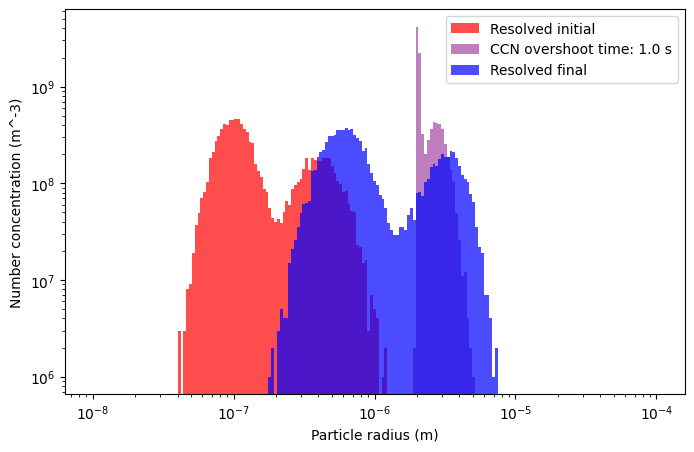

In [6]:
# plot the initial and final distributions
fig, ax = plt.subplots(figsize=(8, 5))

ax.bar(
    edges[:-1],
    number_distribution_binned[0, :],
    width=np.diff(edges),
    align="edge",
    label="Resolved initial",
    color="red",
    alpha=0.7,
)
plot_index = 100
ax.bar(
    edges[:-1],
    number_distribution_binned[plot_index, :],
    width=np.diff(edges),
    align="edge",
    label="CCN overshoot time: {:.1f} s".format(time[plot_index]),
    color="purple",
    alpha=0.5,
)
ax.bar(
    edges[:-1],
    number_distribution_binned[-1, :],
    width=np.diff(edges),
    align="edge",
    label="Resolved final",
    color="blue",
    alpha=0.7,
)
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlabel("Particle radius (m)")
ax.set_ylabel("Number concentration (m^-3)")
ax.legend()
plt.show()

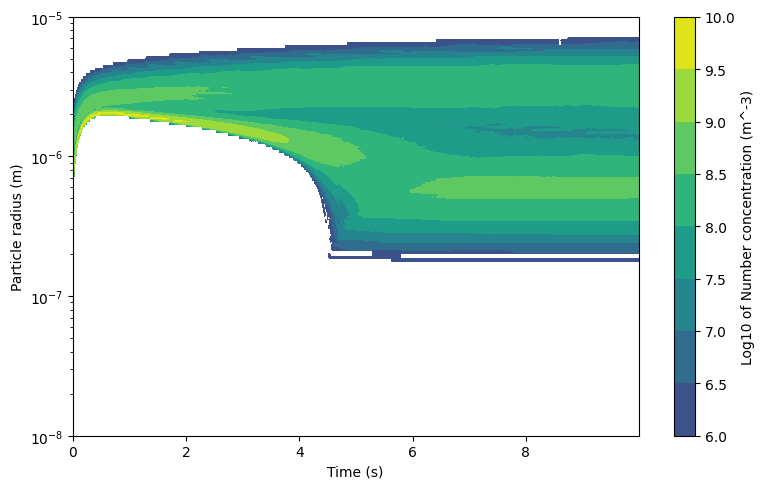

In [7]:
fig, ax = plt.subplots(figsize=(8, 5))

# Swap X and Y to reverse axes
X, Y = np.meshgrid(
    time, edges[:-1]
)  # Now time is on the x-axis and edges on the y-axis

# Plot the contour with updated X and Y
log_of_number_distribution_binned = np.log10(
    number_distribution_binned,
    out=np.nan * np.ones_like(number_distribution_binned),
    where=number_distribution_binned > 0,
)
contour = ax.contourf(
    X,
    Y,
    log_of_number_distribution_binned.T,
    cmap="viridis",
    vmin=5,
)

# Add the color bar
cbar = fig.colorbar(contour)
cbar.set_label("Log10 of Number concentration (m^-3)")

ax.set_ylim([1e-8, 1e-5])  # Set limits for y-axis

# Set axis labels
ax.set_yscale("log")  # Log scale for particle radius on y-axis
ax.set_xlabel("Time (s)")
ax.set_ylabel("Particle radius (m)")
fig.tight_layout()
plt.show()

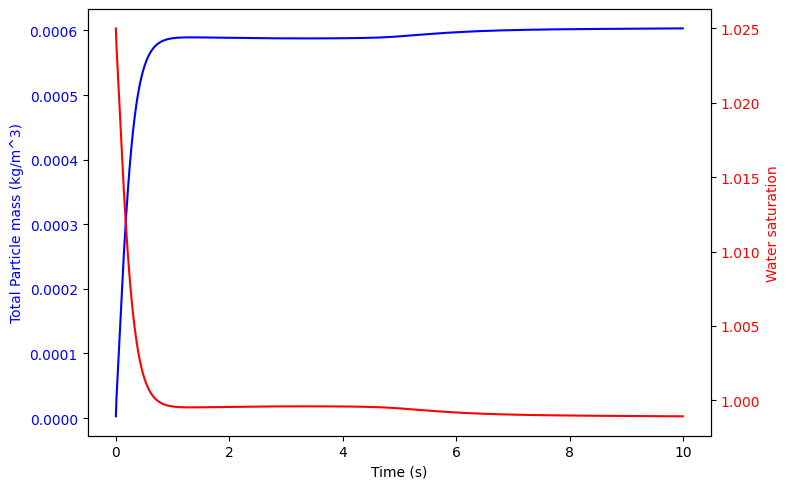

In [8]:
# plot the total mass and water saturation on twin y-axis
fig, ax1 = plt.subplots(figsize=(8, 5))

ax1.plot(time, total_mass_resolved, label="Total mass", color="blue")
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Total Particle mass (kg/m^3)", color="blue")
ax1.tick_params(axis="y", labelcolor="blue")

ax2 = ax1.twinx()
ax2.plot(time, water_saturation_in_time, label="Water saturation", color="red")
ax2.set_ylabel("Water saturation", color="red")
ax2.tick_params(axis="y", labelcolor="red")

fig.tight_layout()
plt.show()

## Summary

This tutorial demonstrates how to run a particle resolved model. We performed a cloud condensation simulation and visualized the results. We can see once the aerosol particles activate there is a redistribution of water vapor to the larger particles as the smaller ones are out of equilibrium and evaporate.